In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
train=pd.read_csv("./train.csv")
test=pd.read_csv("./test.csv")
submit_sample=pd.read_csv("./sample_submit.csv")

df = pd.concat([train, test], sort=False)
df.info()
df.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 399
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        2000 non-null   int64  
 1   age       2000 non-null   int64  
 2   sex       2000 non-null   object 
 3   bmi       2000 non-null   float64
 4   children  2000 non-null   int64  
 5   smoker    2000 non-null   object 
 6   region    2000 non-null   object 
 7   charges   1600 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 140.6+ KB


,id,age,sex,bmi,children,smoker,region,charges
0,0,26,male,32.665465,3,no,southeast,0.0
1,1,41,male,29.798725,1,no,southwest,0.0
2,2,28,male,32.722029,0,yes,northwest,1.0
3,3,20,female,38.429831,2,no,southeast,0.0
4,4,45,female,29.641854,1,no,northwest,0.0
5,5,20,male,37.785937,2,yes,southeast,1.0
6,6,37,male,43.393374,2,no,northeast,0.0
7,7,41,female,32.280407,1,no,northeast,0.0
8,8,40,male,28.865828,1,no,northeast,0.0
9,9,54,female,33.870887,2,no,northeast,0.0


# Pandas Profiling

In [3]:
# import pandas_profiling

# df.profile_report()

### Divide dataset into two parts (categorical , numerical)

In [4]:
categorical, numerical = [],[]
for z in df.columns:
    t = df.dtypes[z]
    if t=='object':
        categorical.append(z)
    else:
        numerical.append(z)
print("CategoricaL:\n{}".format(categorical))
print("\nNumericaL:\n{}".format(numerical))

CategoricaL:
['sex', 'smoker', 'region']

NumericaL:
['id', 'age', 'bmi', 'children', 'charges']


### Heat map for Correlation coefficient

<AxesSubplot:>

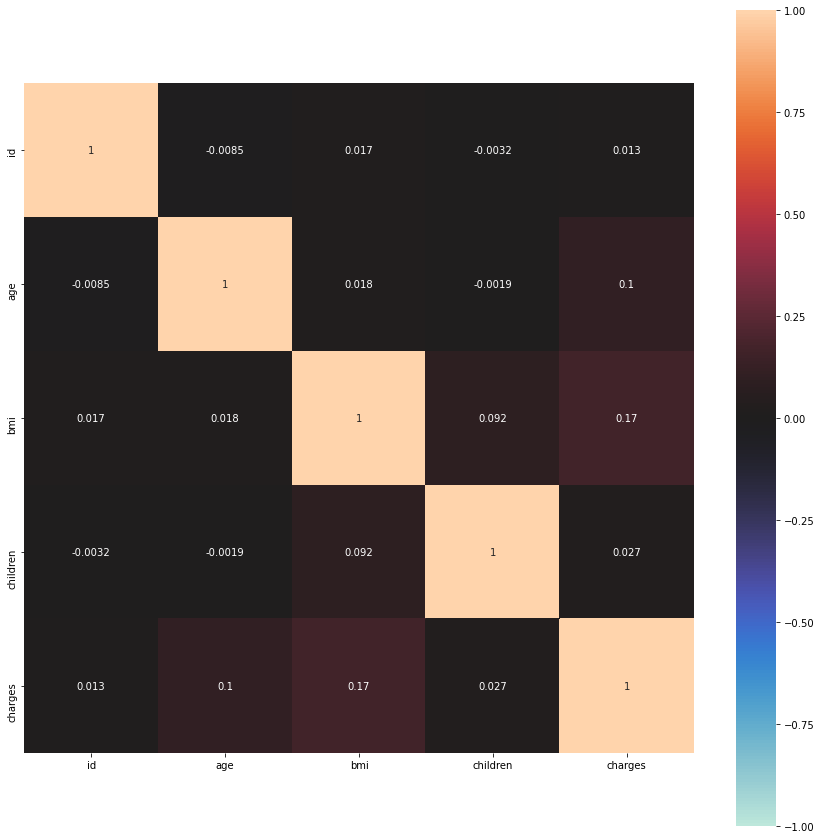

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = df.corr()
plt.figure(figsize=(15, 15)) 
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0, square=True, annot=True)

### Scatter plot

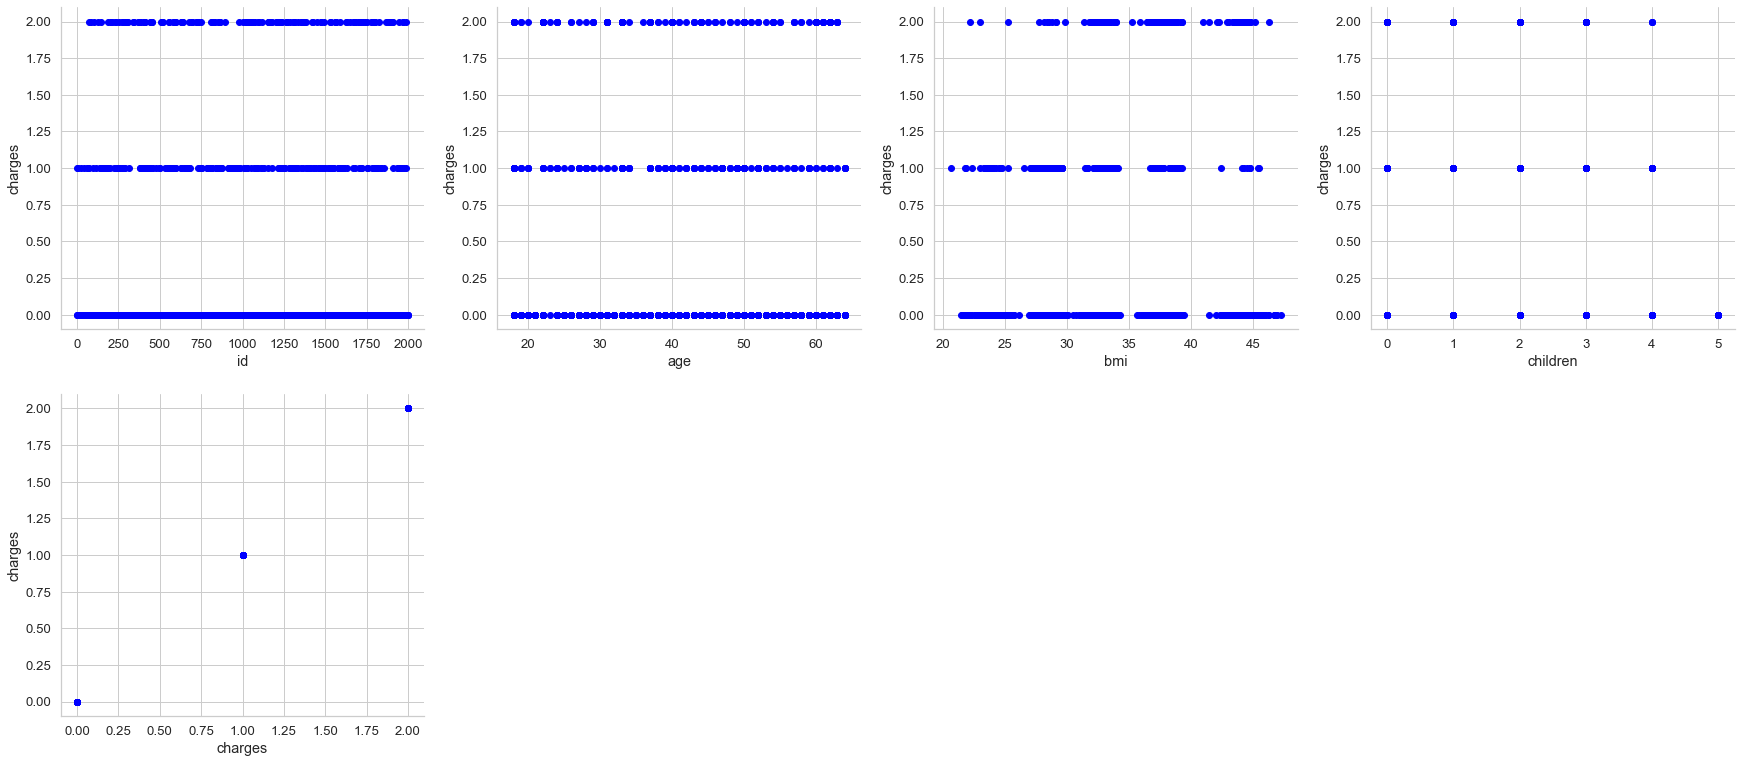

In [6]:
# We shall plot these figures
plt.figure(figsize=(30, 70))
sns.set(font_scale= 1.2)
sns.set_style('whitegrid')

for i, features in enumerate(numerical):
    plt.subplot(10, 4, i+1)
    plt.scatter(data=df.iloc[:len(train)], x=features, y='charges', color ="blue")
    plt.xlabel(features)
    plt.ylabel('charges')
    
sns.despine()

### Creating Dummy values

In [7]:
df =pd.get_dummies(df, columns=categorical, drop_first=True)

### Separate Data

In [8]:
#df = pd.get_dummies(df)
train = df[:len(train)]
test = df[len(train):]
df.head()

,id,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0,26,32.665465,3,0.0,1,0,0,1,0
1,1,41,29.798725,1,0.0,1,0,0,0,1
2,2,28,32.722029,0,1.0,1,1,1,0,0
3,3,20,38.429831,2,0.0,0,0,0,1,0
4,4,45,29.641854,1,0.0,0,0,1,0,0


### LightGBM

In [9]:
y_train = train['charges']
X_train = train.drop(['charges'], axis=1)
X_test = test.drop(['charges'], axis=1)


In [10]:
#import optuna.integration.lightgbm as lgb # Optuna 
import lightgbm as lgb 
from sklearn.model_selection import KFold

In [19]:
y_lgb_preds = []
models = []
y_lgb_oof_train = np.zeros((len(X_train),3))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'task' : 'train',
    'boosting_type' : 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'metric' : 'multi_logloss',
    'max_bin' : 255,
    'num_leaves' : 31,
    'learning_rate' : 0.05,
    'feature_fraction' : 0.9,
    'bagging_fraction' : 0.8,
    'bagging_freq': 5,
    'verbose' : -1
}

# Cross Validation
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.iloc[train_index, :]
    X_val = X_train.iloc[valid_index, :]
    y_tr = y_train.iloc[train_index]
    y_val = y_train.iloc[valid_index]
    
    # Train Dataset
    lgb_train = lgb.Dataset(X_tr, y_tr)

    # Evaluation Dataset (early_stopping_rounds)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    evals_result = {} #結果を格納するための辞書
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['train','eval'],
                    num_boost_round=1000,
                    early_stopping_rounds=100,
                    verbose_eval=100,
                    evals_result=evals_result
                   )
    # Out-of-hold of train data
    y_lgb_oof_train[valid_index] = \
        gbm.predict(X_val, num_iteration=gbm.best_iteration)
    
    # Prediction for X_test data
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
    # Append Prediction data 
    y_lgb_preds.append(y_pred)
    models.append(gbm)


Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.0994878	eval's multi_logloss: 0.351058
Early stopping, best iteration is:
[68]	train's multi_logloss: 0.160273	eval's multi_logloss: 0.337798
Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.0952632	eval's multi_logloss: 0.34727
Early stopping, best iteration is:
[47]	train's multi_logloss: 0.21633	eval's multi_logloss: 0.336055
Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.0894653	eval's multi_logloss: 0.433588
Early stopping, best iteration is:
[36]	train's multi_logloss: 0.245138	eval's multi_logloss: 0.379087
Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.0923735	eval's multi_logloss: 0.387845
Early stopping, best iteration is:
[55]	train's multi_logloss: 0.186645	eval's multi_logloss: 0.360399
Training until validation scores don't improve for 100 rounds


In [20]:
y_lgb_oof_train[valid_index].shape
gbm.predict(X_val, num_iteration=gbm.best_iteration)

array([[0.96773719, 0.02161381, 0.010649  ],
       [0.91522768, 0.0692179 , 0.01555443],
       [0.96288366, 0.02686304, 0.0102533 ],
       [0.9530443 , 0.03552257, 0.01143312],
       [0.96380178, 0.02524111, 0.01095711],
       [0.94514301, 0.04021862, 0.01463837],
       [0.912201  , 0.06224716, 0.02555184],
       [0.96463524, 0.02555516, 0.00980961],
       [0.9741353 , 0.01582363, 0.01004107],
       [0.92896992, 0.05675551, 0.01427456],
       [0.24985046, 0.70569348, 0.04445606],
       [0.14557664, 0.21598788, 0.63843548],
       [0.97405694, 0.01573049, 0.01021257],
       [0.88387013, 0.045471  , 0.07065887],
       [0.91174702, 0.06708156, 0.02117142],
       [0.95755409, 0.02772666, 0.01471925],
       [0.96136072, 0.02939502, 0.00924427],
       [0.96267076, 0.02498271, 0.01234652],
       [0.97059432, 0.01915115, 0.01025454],
       [0.93877227, 0.04750468, 0.01372305],
       [0.63933525, 0.32469007, 0.03597468],
       [0.28496326, 0.66834694, 0.0466898 ],
       [0.